## Import Libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import seaborn as sns
import numpy as np
import pandas as pd
import torch
from datetime import date, timedelta
from torch import nn,optim
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [2]:
# If a gpu is available, set gpu else cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Import the Data

In [3]:
df = pd.read_csv('train.csv', usecols=[1,2,3,4,5])
df.head()

C:\Users\Pranav\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,date,store_nbr,item_nbr,unit_sales,onpromotion
0,2013-01-01,25,103665,7.0,NaN
1,2013-01-01,25,105574,1.0,NaN
2,2013-01-01,25,105575,2.0,NaN
3,2013-01-01,25,108079,1.0,NaN
4,2013-01-01,25,108701,1.0,NaN


## Data Transformation and Visualization

In [4]:
# Defined a function to plot predicted values vs actual values
def plot_prediction(data,tens):
    month = data['date'][split:].to_numpy()

    plt.figure(figsize = (18,6))
    plt.plot(month,y_test)
    plt.plot(month,tens.cpu().numpy()[:,-1])
    plt.legend(['Actual Values', 'Predicted Values'], loc='upper left')
    plt.xticks(rotation=90)
    plt.xlabel("Year")
    plt.ylabel("Unit Sales")
    plt.title("Unit Sales vs Year")
    
    ax = plt.gca()
    ax.xaxis.set_major_locator(plticker.MultipleLocator(base=15.0))
    plt.show()

In [5]:
def plot_comp(mse_lst,time_lst):
    fig, ax1 = plt.subplots(figsize = (18,6))

    ax1.set_xlabel('Model Number')
    ax1.set_ylabel('MSE',color='tab:red')
    ax1.plot(list(range(0,len(mse_lst))),np.array(mse_lst), color='tab:red')

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    ax2.set_ylabel('Time (in ms)',color='tab:blue')  # we already handled the x-label with ax1
    ax2.plot(list(range(0,len(mse_lst))),np.array(time_lst), color='tab:blue')
    ax2.tick_params(axis='y')

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

In [6]:
df_final = pd.DataFrame(df.groupby(by=['date'])['unit_sales'].sum())
df_final = df_final.reset_index()
df_final.head()

,date,unit_sales
0,2013-01-01,2511.619
1,2013-01-02,496092.418
2,2013-01-03,361429.231
3,2013-01-04,354459.677
4,2013-01-05,477350.121


In [7]:
# The below function creates lag observation(t-n)
def transformer(cnt):
    lst = []
    col_values= []
    length = len(df_final)
    temp_df = df_final.drop(list(range(cnt + 1)))
    
    for i in range(length-1,length-cnt-1,-1):
        lst.append(df_final["unit_sales"].array[cnt:i])
        temp_df[f't-{length - i}'] = df_final["unit_sales"].array[cnt:i]
        cnt -= 1

    return temp_df.reset_index(drop = True)

In [8]:
split = int(round(0.70 * len(df_final),0))

def data_split(data):
    # Split data into training and testing sets
    data_train = data[:split]
    data_test  = data[split:]
        
    min_max_scaler = MinMaxScaler()
    
    mm = min_max_scaler.fit(data_train.drop('date',axis = 1))
    data_train = pd.DataFrame(mm.transform(data_train.drop('date',axis = 1)),columns=data_train.drop('date',axis = 1).columns, index=data_train.drop('date',axis = 1).index)
    data_test  = pd.DataFrame(mm.transform(data_test.drop('date',axis = 1)),columns=data_test.drop('date',axis = 1).columns, index=data_test.drop('date',axis = 1).index)
    
    # Split data into dependent and independent variables
    X_train = data_train.drop(['unit_sales'],axis = 1).to_numpy()
    y_train = data_train['unit_sales'].to_numpy()
    X_test  = data_test.drop(['unit_sales'],axis = 1).to_numpy()
    y_test  = data_test['unit_sales'].to_numpy()
    
    return X_train,y_train,X_test,y_test

# Defined a function to convert numpy arrays into tensors
def data_prep(X_train,y_train,X_test,y_test):
    
    # Convert numpy arrays into tensors
    X_train = torch.tensor(X_train).float()
    y_train = torch.tensor(y_train).view(-1, 1).float()

    X_test = torch.tensor(X_test).float()
    y_test = torch.tensor(y_test).view(-1, 1).float()

    return X_train,y_train,X_test,y_test
    

def loader(X_train,y_train,X_test,y_test):
    # Build a data loader object from the two tensors for training data
    train_datasets = torch.utils.data.TensorDataset(X_train, y_train)
    train_iter = torch.utils.data.DataLoader(train_datasets, batch_size=round(len(X_train)/8), shuffle=False)

    # Build a data loader object from the two tensors for testing data
    test_datasets = torch.utils.data.TensorDataset(X_test, y_test)
    test_iter = torch.utils.data.DataLoader(test_datasets, batch_size=round(len(X_test)), shuffle=False)
    
    return train_iter,test_iter

## Plain Backpropogation

In [9]:
# Define the number of lag columns in the series
num_cols = 12
bas_df = transformer(num_cols)
bas_df.head()

,date,unit_sales,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,t-10,t-11,t-12
0,2013-01-14,293328.362,464638.548,403257.212,289737.685,258982.003,302530.809,318347.778,336122.801,519695.401,477350.121,354459.677,361429.231,496092.418
1,2013-01-15,298969.550,293328.362,464638.548,403257.212,289737.685,258982.003,302530.809,318347.778,336122.801,519695.401,477350.121,354459.677,361429.231
2,2013-01-16,318347.914,298969.550,293328.362,464638.548,403257.212,289737.685,258982.003,302530.809,318347.778,336122.801,519695.401,477350.121,354459.677
3,2013-01-17,267498.516,318347.914,298969.550,293328.362,464638.548,403257.212,289737.685,258982.003,302530.809,318347.778,336122.801,519695.401,477350.121
4,2013-01-18,296130.850,267498.516,318347.914,298969.550,293328.362,464638.548,403257.212,289737.685,258982.003,302530.809,318347.778,336122.801,519695.401


In [10]:
#Split into train and test and create data loader objects
X_train,y_train,X_test,y_test = data_split(bas_df)
X_train,y_train,X_test,y_test = data_prep(X_train,y_train,X_test,y_test)
train_iter,test_iter = loader(X_train,y_train,X_test,y_test)

In [11]:
# In pytorch the model is represented by a python class that inherits from the module class
class PlainModel(nn.Module):
    def __init__(self,nodes):
        super().__init__()
        # Define hidden layer with a variable number of inputs and outputs
        self.hidden = nn.Linear(nodes, 2*nodes)
        # Define output layer with a variable number of inputs and 1 output
        self.output = nn.Linear(2*nodes, 1)
        # Define sigmoid activation function 
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Define the sequence of operation and pass the input tensor through each operation
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        
        return x

In [12]:
# Define a function to calculate the validation MSE
def test(model):
    # Use no_grad to allow us to perform regular Python operations on tensors, independent of PyTorch’s computation graph
    with torch.no_grad():
        # Loop through the test data
        for inputs, labels in test_iter:
            # Move the tensors to the device selected above (GPU or CPU)
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Enter model evaluation mode
            model.eval()
            # Make predictions on the validation dataset
            y_pred = model(inputs)
            # Calculate the mean squared error for the predictions
            loss = lossfunc(y_pred, labels)
    
    # Return MSE and prediction values
    return loss.item(),y_pred

In [13]:
# Initialze the loss function as Mean Square Error loss
lossfunc = nn.MSELoss()

#Define a function to train the model
def train(model, num_epochs = 200,recurr = False):
    # Initialize the optimizer as Stochastic Gradient Descent and initialize the learning rate
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # Loop over the epochs
    for epoch in range(num_epochs):
        # Check if the model being passed in is a recurrent neural network
        if recurr == True:
            model.hidden = model.hidden_reset()
        # Loop through each batch in the training dataset
        for inputs, labels in train_iter:
            # Move the tensors to the device selected above (GPU or CPU)
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Call the model to perform the forward computation
            outputs = model(inputs)
            # Compute the loss given our outputs and labels
            loss = lossfunc(outputs, labels)
            # Since Gradients are accumulated, we have to zero them
            optimizer.zero_grad()
            # Compute Gradients using backpropogation
            loss.backward()
            # Update weights based on the current gradient
            optimizer.step()

    # Store the final validation and training loss
    test_mse,y_pred = test(model)
    mse = loss.item()
            
    return mse,test_mse,y_pred

In [14]:
#Define a function to train the model. This function will terminate execution if mean squared error reaches a satisfactory value
def comp_train(model, num_epochs = 200,recurr = False):
    # Initialize the optimizer as Stochastic Gradient Descent and initialize the learning rate
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    # Loop over the epochs
    for epoch in range(num_epochs):
        # Check if the model being passed in is a recurrent neural network
        if recurr == True:
            model.hidden = model.hidden_reset()
        # Loop through each batch in the training dataset
        for inputs, labels in train_iter:
            #Set the model to train mode
            model.train()
            # Move the tensors to the device selected above (GPU or CPU)
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Call the model to perform the forward computation
            outputs = model(inputs)
            # Compute the loss given our outputs and labels
            loss = lossfunc(outputs, labels)
            # Since Gradients are accumulated, we have to zero them
            optimizer.zero_grad()
            # Compute Gradients using backpropogation
            loss.backward()
            # Update weights based on the current gradient
            optimizer.step()

            # Compute the validation loss after each weight updation.
            test_mse = test(model)
            # If validation loss is below a satisfactory threshold, terminate execution.
            if test_mse[0] < 0.007:
                break
        else:
            continue
        break

In [15]:
# Initialize objects to track execution time
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

# Begin recording execution time
start.record()
# Initialize model
model = PlainModel(num_cols)
model.to(device)
# Train model
pb_mse,pbt_mse,pby_pred = train(model,500)
# Stop recording execution time
end.record()
# Wait for kernels in all streams of a cuda device to complete
torch.cuda.synchronize()
# Compute and store execution timep
pb_time = start.elapsed_time(end)

In [16]:
print(f"The training mean squared error for Plain Backpropogation is: {pb_mse}")
print(f"The validation mean squared error for Plain Backpropogation is: {pbt_mse}")
print(f"The computational effort for Plain Backpropogation in milliseconds is: {pb_time}")

The training mean squared error for Plain Backpropogation is: 0.000450798193924129
The validation mean squared error for Plain Backpropogation is: 0.010801512748003006
The computational effort for Plain Backpropogation in milliseconds is: 9829.509765625


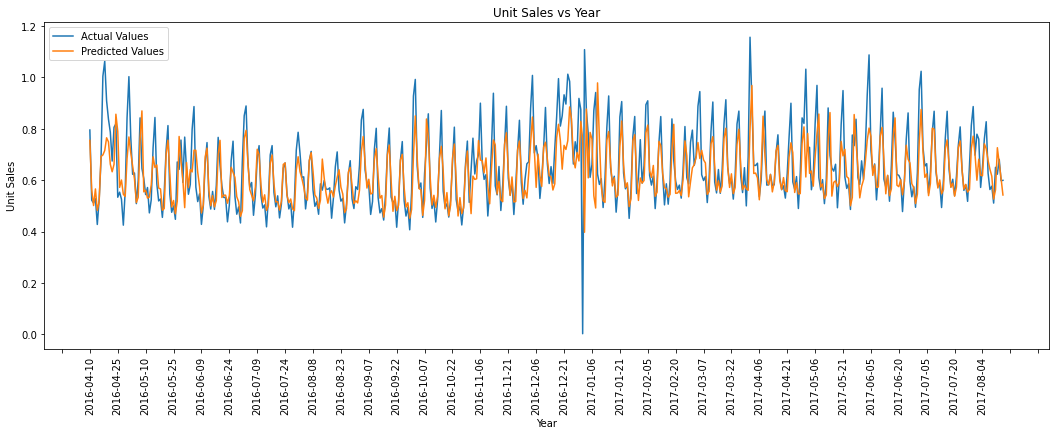

In [17]:
plot_prediction(bas_df,pby_pred)

## Backpropogation through time

In [18]:
# Define a function to reshape array into a 3 dimensional array
def array_reshape(arr):
    return np.reshape(arr,(len(arr),arr.shape[1],1))

In [19]:
# Transform the data to hold lag values
num_cols = 1
rnn_df = transformer(num_cols)
rnn_df.head()

,date,unit_sales,t-1
0,2013-01-03,361429.231,496092.418
1,2013-01-04,354459.677,361429.231
2,2013-01-05,477350.121,354459.677
3,2013-01-06,519695.401,477350.121
4,2013-01-07,336122.801,519695.401


In [20]:
# Transform the data and create data loader objects
X_train,y_train,X_test,y_test = data_split(rnn_df)
X_train = array_reshape(X_train)
X_test = array_reshape(X_test)
X_train,y_train,X_test,y_test = data_prep(X_train,y_train,X_test,y_test) 
train_iter,test_iter = loader(X_train,y_train,X_test,y_test)

In [21]:
# IDefine a class for the RNN model
class RecurrentModel(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size,num_layers=1):
        super().__init__()
        # Initialize attributes used by the model
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        
        # Define an RNN layer
        self.rnn = nn.RNN(self.input_size, self.hidden_size,num_layers = self.num_layers)
    
    # Define a method to set the hidden state at the beginning of every epoch
    def hidden_reset(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_size),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_size))

    def forward(self, x):
        # Define the sequence of operation and pass the input tensor through each operation
        x,_ = self.rnn(x.view(len(x), self.batch_size, -1))
        
        return x[:,:,-1][:,-1].view(len(x),1)

In [22]:
rnn_mse_lst = []
rnnt_mse_lst = []
rnny_pred_lst = []
rnn_time = []
for i in [5,8,14,18]:
    for j in [1,2,3]:
# Initialize objects to track execution time
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)

        # Begin recording execution time
        start.record()
        # Initialize model
        model = RecurrentModel(input_size = 1, hidden_size = i, batch_size = num_cols,num_layers=j)
        model.to(device)
        rnn_mse,rnnt_mse,rnny_pred = train(model,800,True)
        rnn_mse_lst.append(rnn_mse)
        rnnt_mse_lst.append(rnnt_mse)
        rnny_pred_lst.append(rnny_pred)
        # Stop recording execution time
        end.record()
        # Wait for kernels in all streams of a cuda device to complete
        torch.cuda.synchronize()
        # Compute and store execution time
        rnn_time.append(start.elapsed_time(end))

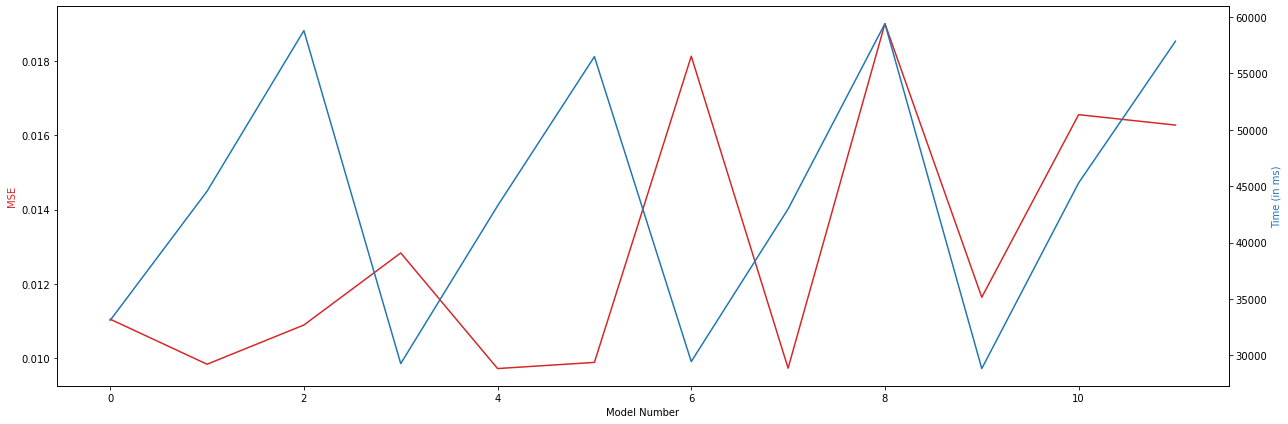

In [23]:
plot_comp(rnnt_mse_lst,rnn_time)

In [24]:
best_model_rnn = rnnt_mse_lst.index(min(rnnt_mse_lst))
print(f"The best training mean squared error for Backpropogation through time is: {rnn_mse_lst[best_model_rnn]}")
print(f"The best validation mean squared error for Backpropogation through time is: {rnnt_mse_lst[best_model_rnn]}")
print(f"The best computational effort for Backpropogation through time in milliseconds is: {rnn_time[best_model_rnn]}")

The best training mean squared error for Backpropogation through time is: 0.00012777591473422945
The best validation mean squared error for Backpropogation through time is: 0.009726189076900482
The best computational effort for Backpropogation through time in milliseconds is: 43257.125


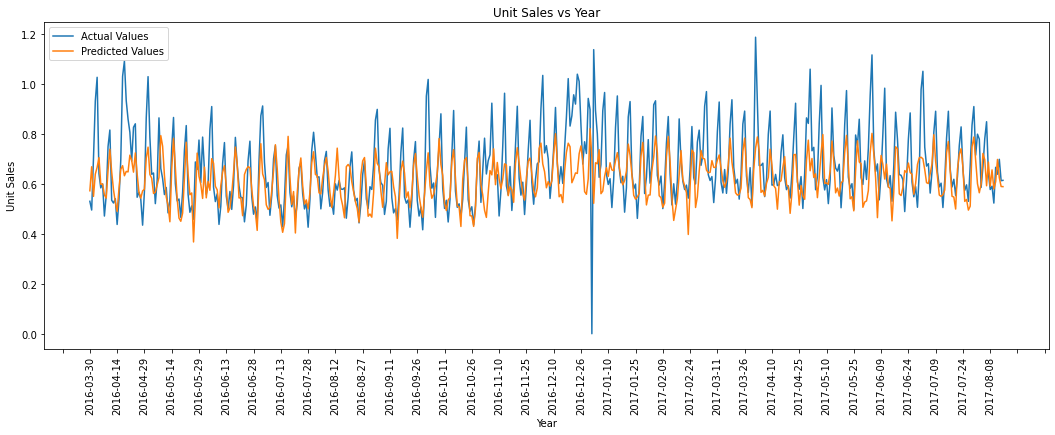

In [25]:
plot_prediction(rnn_df,rnny_pred)

## LSTM

In [26]:
# Define a class for the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size,num_layers=1):
        super().__init__()
        # Initialize attributes used by the model
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        
        # Define an LSTM object which consists of several layers
        self.lstm = nn.LSTM(self.input_size, self.hidden_size,num_layers = self.num_layers)
        
    # Define a method to set the hidden state at the beginning of every epoch
    def hidden_reset(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_size),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_size))
        
    def forward(self, x):
        # Define the sequence of operation and pass the input tensor through each operation
        x,_ = self.lstm(x.view(len(x), self.batch_size, -1))
        
        return x[:,:,-1][:,-1].view(len(x),1)

In [27]:
lstm_mse_lst = []
lstmt_mse_lst = []
lstm_pred_lst = []
lstm_time = []
for i in [5,8,14,18]:
    for j in [1,2,3]:
        # Initialize objects to track execution time
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)

        # Begin recording execution time
        start.record()
        # Initialize model
        model = LSTMModel(input_size = 1, hidden_size = i, batch_size = num_cols,num_layers=j)
        model.to(device)
        lstm_mse,lstmt_mse,lstmy_pred = train(model,1500,True)
        lstm_mse_lst.append(lstm_mse)
        lstmt_mse_lst.append(lstmt_mse)
        lstm_pred_lst.append(lstmy_pred)
        # Stop recording execution time
        end.record()
        # Wait for kernels in all streams of a cuda device to complete
        torch.cuda.synchronize()
        # Compute and store execution time
        lstm_time.append(start.elapsed_time(end))

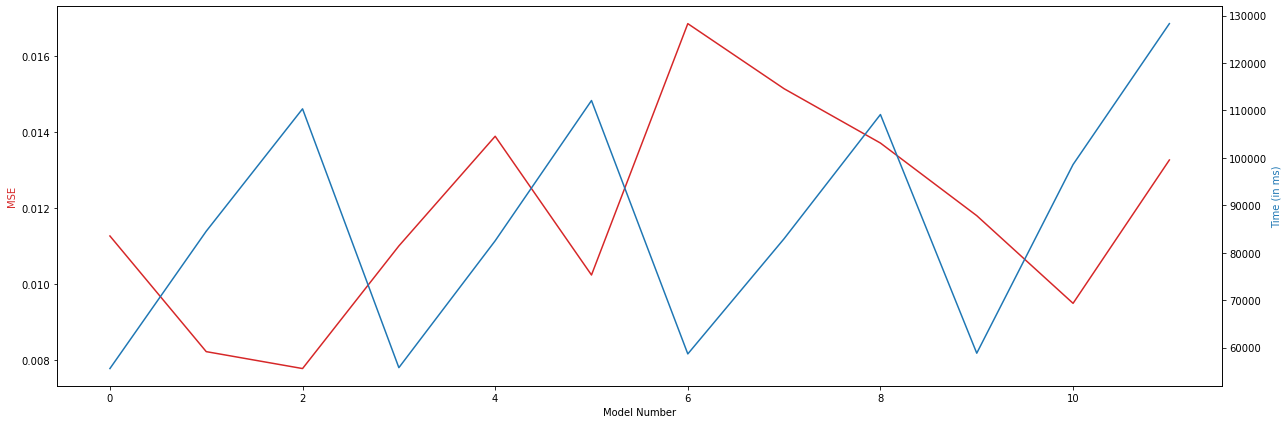

In [28]:
plot_comp(lstmt_mse_lst,lstm_time)

In [29]:
best_model_lstm = lstmt_mse_lst.index(min(lstmt_mse_lst))
print(f"The training mean squared error for LSTM is: {lstm_mse_lst[best_model_lstm]}")
print(f"The validation mean squared error for LSTM is: {lstmt_mse_lst[best_model_lstm]}")
print(f"The computational effort for LSTM in milliseconds is: {lstm_time[best_model_lstm]}")

The training mean squared error for LSTM is: 1.950868636413361e-06
The validation mean squared error for LSTM is: 0.0077735865488648415
The computational effort for LSTM in milliseconds is: 110348.671875


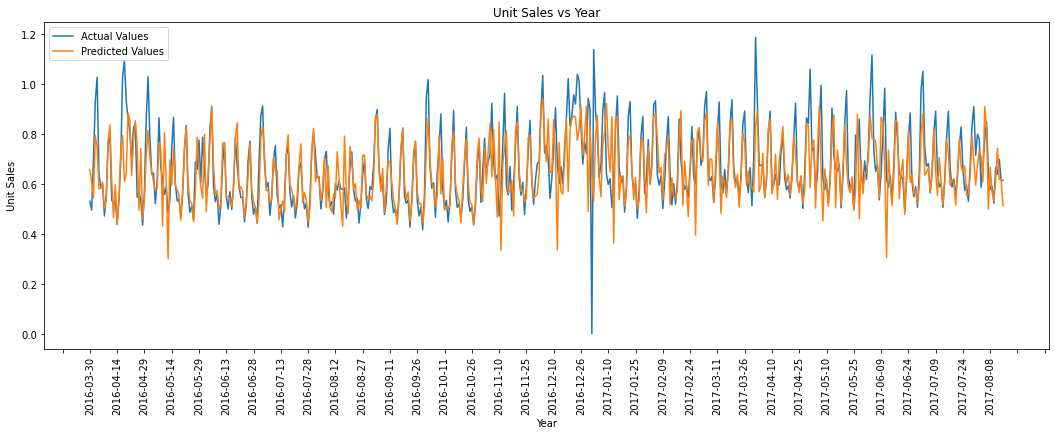

In [30]:
plot_prediction(rnn_df,lstmy_pred)

## GRU

In [31]:
# Define a class for the GRU model
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, batch_size,num_layers=1):
        super().__init__()
        # Initialize attributes used by the model
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        
        # Define hidden layer with 12 inputs and a variable number of outputs
        self.gru = nn.GRU(self.input_size, self.hidden_size,num_layers = self.num_layers)
        
    # Define a method to set the hidden state at the beginning of every epoch
    def hidden_reset(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_size),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_size))
        
    def forward(self, x):
        # Define the sequence of operation and pass the input tensor through each operation
        x,_ = self.gru(x.view(len(x), self.batch_size, -1))
        
        return x[:,:,-1][:,-1].view(len(x),1)

In [32]:
gru_mse_lst = []
grut_mse_lst = []
gru_pred_lst = []
gru_time = []
for i in [5,8,15,18]:
    for j in [1,2,3]:
        # Initialize objects to track execution time
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)

        # Begin recording execution time
        start.record()
        # Initialize model
        model = GRUModel(input_size = 1, hidden_size = i, batch_size = num_cols,num_layers=j)
        model.to(device)
        gru_mse,grut_mse,gruy_pred = train(model,1800,True)
        gru_mse_lst.append(gru_mse)
        grut_mse_lst.append(grut_mse)
        gru_pred_lst.append(gruy_pred)
        # Stop recording execution time
        end.record()
        # Wait for kernels in all streams of a cuda device to complete
        torch.cuda.synchronize()
        # Compute and store execution time
        gru_time.append(start.elapsed_time(end))

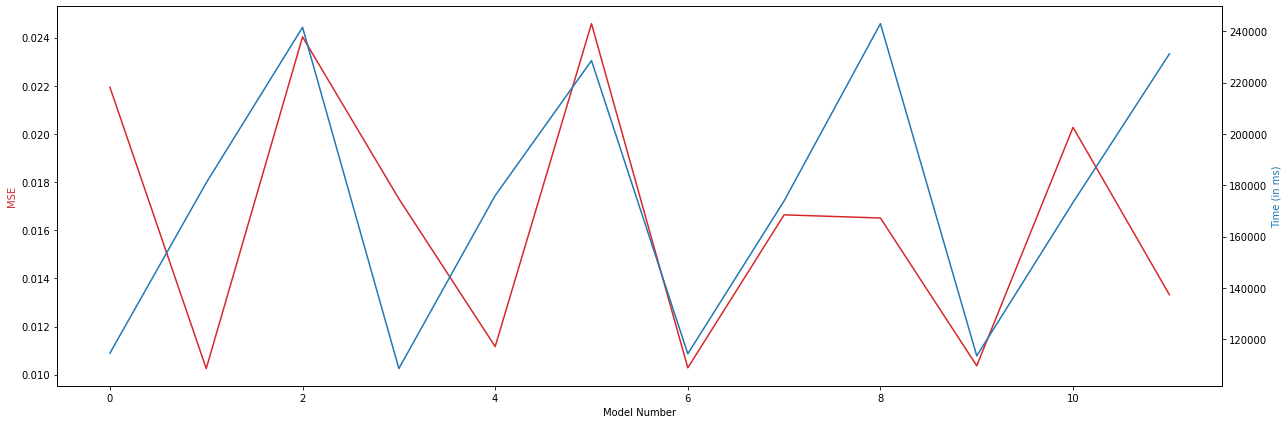

In [33]:
plot_comp(grut_mse_lst,gru_time)

In [34]:
best_model_gru = grut_mse_lst.index(min(grut_mse_lst))
print(f"The training mean squared error for GRU is: {gru_mse_lst[best_model_gru]}")
print(f"The validation mean squared error for GRU is: {grut_mse_lst[best_model_gru]}")
print(f"The computational effort for GRU in milliseconds is: {gru_time[best_model_gru]}")

The training mean squared error for GRU is: 2.3782024072716013e-05
The validation mean squared error for GRU is: 0.010253633372485638
The computational effort for GRU in milliseconds is: 180980.484375


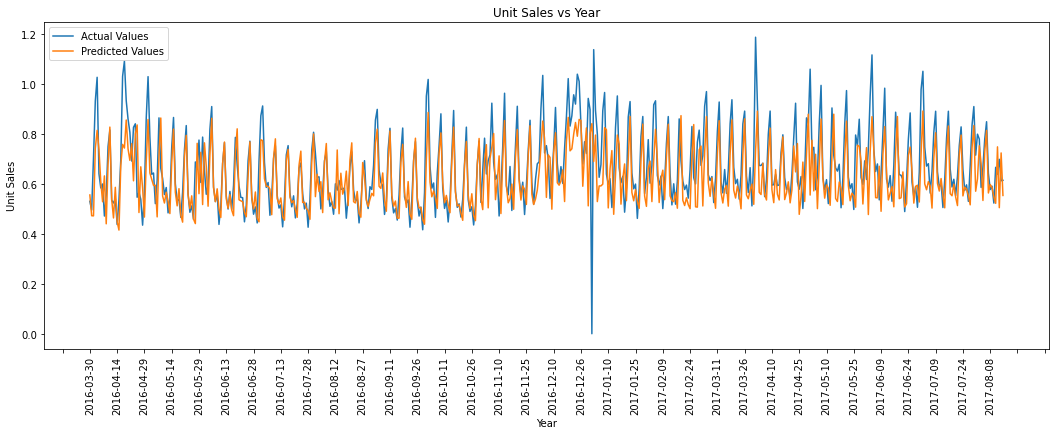

In [35]:
plot_prediction(rnn_df,gruy_pred)

## Model Comparison

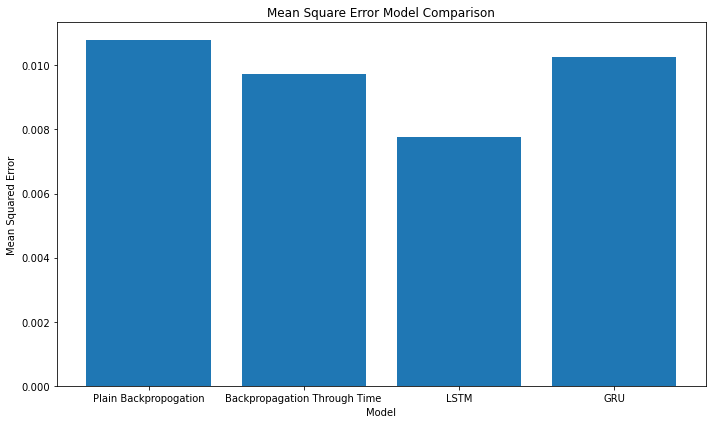

In [37]:
plt.figure(figsize=(10,6))
plt.bar(np.array(['Plain Backpropogation','Backpropagation Through Time','LSTM','GRU']),
    np.array([pbt_mse,rnnt_mse_lst[best_model_rnn],lstmt_mse_lst[best_model_lstm],grut_mse_lst[best_model_gru]]))

plt.xlabel("Model") 
plt.ylabel("Mean Squared Error") 
plt.title("Mean Square Error Model Comparison") 
plt.tight_layout()
plt.show()

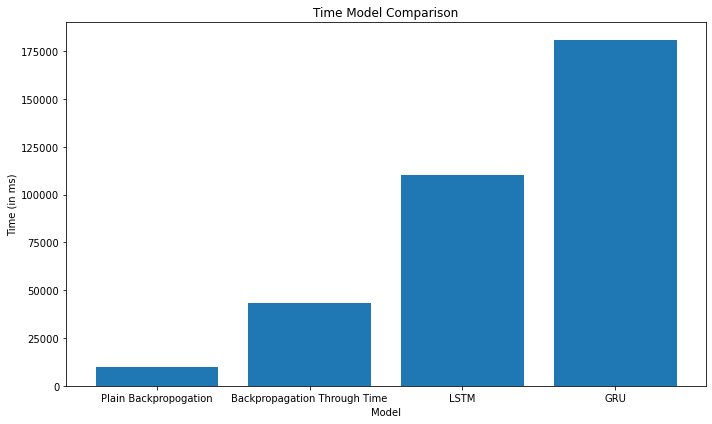

In [39]:
plt.figure(figsize=(10,6))
plt.bar(np.array(['Plain Backpropogation','Backpropagation Through Time','LSTM','GRU']),
    np.array([pb_time,rnn_time[best_model_rnn],lstm_time[best_model_lstm],gru_time[best_model_gru]]))

plt.xlabel("Model") 
plt.ylabel("Time (in ms)") 
plt.title("Time Model Comparison") 
plt.tight_layout()
plt.show()